In [113]:
# Importing the required libraries
import os
import numpy as np

from sklearn.decomposition import PCA
from scipy.signal import lfilter
import matplotlib.pyplot as plt

import librosa
import soundfile as sf
import IPython.display as ipd

import pandas as pd

In [114]:
def plot_pca_components(explained_variance_ratio, num_components_to_keep):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    
    # Set x and y axis limits
    plt.xlim(-0.1*len(explained_variance_ratio), 1.1*len(explained_variance_ratio))
    plt.ylim(0, 1.1 * max(explained_variance_ratio))
    
    plt.xlabel("Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("PCA Component Magnitudes")

    # Mark the retained components
    plt.axvline(x=num_components_to_keep, color='red', linestyle='--', label=f"Retained Components ({num_components_to_keep})")
    plt.legend()

    plt.show()

In [115]:
def apply_pca_lpc(segments, sr, num_components=None, order=16):
    # Extract LPC features
    lpc_features = []
    lpc_original = []
    for segment in segments:
        # Compute LPC coefficients
        lpc = librosa.lpc(segment, order=order)
        lpc_original.append(lpc)
        lpc = lpc[1:] # Drop the first coefficient
        lpc_features.append(lpc)  # Drop the first coefficient
    
    lpc_features = np.array(lpc_features)
    
    # Concatenate LPC features
    data = np.array(lpc_features)
    
    # Apply PCA
    pca = PCA()
    components = pca.fit_transform(data)
    
    # Select the specified number of components based on energy
    if num_components is not None:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        num_components_to_keep = np.argmax(cumulative_variance >= num_components / 100) + 1
        components = components[:, :num_components_to_keep]
    
    return components, pca, lpc_features, lpc_original

In [116]:
def rebuild_audio_lpc(reduced_components, pca, lpc_features, lpc_original, segments, sr, order=16):
    # Pad the reduced components with zeros to match the original shape
    num_original_components = lpc_features.shape[1]
    padding = np.zeros((reduced_components.shape[0], num_original_components - reduced_components.shape[1]))
    reduced_components_padded = np.hstack((reduced_components, padding))
    
    # Reconstruct LPC features
    reconstructed_lpc = pca.inverse_transform(reduced_components_padded.T)
    
    # Rebuild the audio from LPC coefficients
    reconstructed_audio = []
    for i, segment in enumerate(segments):
        reconstructed_filter = [1] + reconstructed_lpc[i]
        reconstructed_filter = reconstructed_filter*np.linalg.norm(np.array(lpc_original[i]))/np.linalg.norm(np.array(reconstructed_filter))
        reconstructed_segment = lfilter(reconstructed_filter, [1], segment)  # Restore the first coefficient
        reconstructed_audio.append(reconstructed_segment)
    
    reconstructed_audio = np.concatenate(reconstructed_audio)
    return reconstructed_audio

In [117]:
def load_and_segment(folder, segment_duration=10, max_files=10):
    # Segment the audio
    files = []
    segments = []
    segments_by_file = []
    for filename in os.listdir(folder):
        if filename.endswith('.wav') and (not filename.endswith('_pca.wav')):
            file_path = os.path.join(folder, filename)
            # Check if the .wav file exists
            if not os.path.isfile(file_path):
                continue
            else:
                files.append(file_path)
                y, sr = librosa.load(file_path, sr=None)

                # Calculate the number of segments
                num_segments = len(y) // (sr * segment_duration)
                segments_by_file.append(num_segments)

                for i in range(num_segments):
                    start = i * sr * segment_duration
                    end = (i + 1) * sr * segment_duration
                    segments.append(y[start:end])
                
                if len(files) == max_files:
                    break

    return files, segments, segments_by_file, sr


In [118]:
def apply_pca_spectrum(segments, preserved_energy=None, n_fft=2048):
    # Compute the STFT (Short-Time Fourier Transform) for each segment
    print('Generating spectrum features...')
    spectrum_features = []
    spectrum_phases = []
    for i, segment in enumerate(segments):
        if i % (len(segments) // 10) == 0:
            print(f"{int(i / len(segments) * 100)}/100%")
        spectrum = librosa.stft(segment, n_fft=n_fft)
        spectrum_shape = spectrum.shape
        spectrum_features.append(np.abs(spectrum.flatten()))
        spectrum_phases.append(np.angle(spectrum).flatten())
    
    spectrum_features = np.array(spectrum_features)
    print('spectrum_features:', spectrum_features.shape)
    
    # Apply PCA
    pca = PCA()
    print('Performing PCA on spectrum features...')
    components = pca.fit_transform(spectrum_features)
    print('components:', components.shape)

    # Select the specified number of components based on energy
    print('Reducing compoments...')
    if 0 < preserved_energy < 100:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        num_components_to_keep = np.argmax(cumulative_variance >= preserved_energy / 100) + 1
        reduced_components = components[:, :num_components_to_keep]
    else:
        reduced_components = components
    print('cut at:', num_components_to_keep)
    
    return components, reduced_components, pca, spectrum_phases, spectrum_shape  


In [119]:
def rebuild_audio_spectrum(components, reduced_components, pca, spectrum_phases, spectrum_shape, segments, n_fft=2048):
    print('Rebuilding audio...')
    # Pad the reduced components_mag with zeros to match the original shape
    if reduced_components.shape[1] < components.shape[1]:
        padding = np.zeros((reduced_components.shape[0], components.shape[1] - reduced_components.shape[1]))
        reduced_components = np.hstack((reduced_components, padding))
    print('reduced_components:', reduced_components.shape)

    # Inverse transform the PCA components
    print('Applying inverse PCA ...')
    reconstructed_features = pca.inverse_transform(reduced_components)
    print('reconstructed_features:', reconstructed_features.shape)

    # Generate the real and imaginary parts
    reconstructed_spectrum_real = reconstructed_features * np.cos(spectrum_phases)
    reconstructed_spectrum_imag = reconstructed_features * np.sin(spectrum_phases)
    reconstructed_spectrum = reconstructed_spectrum_real + 1j * reconstructed_spectrum_imag
    print('reconstructed_spectrum:', reconstructed_spectrum.shape)
    
    # Perform the inverse STFT to recover the time-domain signal
    print('Reconstructing audio segments...')
    reconstructed_audio = []
    for i, spectrum in enumerate(reconstructed_spectrum):
        if i % (len(reconstructed_spectrum) // 10) == 0:
            print(f"{int(i / len(segments) * 100)}/100%")
        spectrum = spectrum.reshape(spectrum_shape)
        segment = librosa.istft(spectrum, n_fft=n_fft, length=len(segments[0]))
        reconstructed_audio.append(segment)

    reconstructed_audio = np.concatenate(reconstructed_audio)
    
    return reconstructed_audio

In [120]:
# Process files using spectrum as feature
folder = r'C:\Users\tfmac\sound_of_rainfall\morning\moderate'
max_files = 30
segment_duration = 10

files, segments, segments_by_file, sr = load_and_segment(folder, segment_duration, max_files)

n_fft = 2048 # sr // 100

In [121]:
print('Number of files:', len(files))
print('Number of segments:', len(segments))
print('Number of segments by file:', segments_by_file)  # Number of segments per file 

Number of files: 30
Number of segments: 180
Number of segments by file: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [122]:
# Perform PCA based on spectrum
# Keep {preserved_energy}% of the variance
preserved_energy = 75

# Apply PCA to the frequency spectrum features
components, reduced_components, pca, spectrum_phases, spectrum_shape = apply_pca_spectrum(segments, preserved_energy, n_fft)

Generating spectrum features...
0/100%
10/100%
20/100%
30/100%
40/100%
50/100%
60/100%
70/100%
80/100%
90/100%
spectrum_features: (180, 961450)
Performing PCA on spectrum features...
components: (180, 180)
Reducing compoments...
cut at: 66


components energy length: (180,)
num_components_to_keep: 66


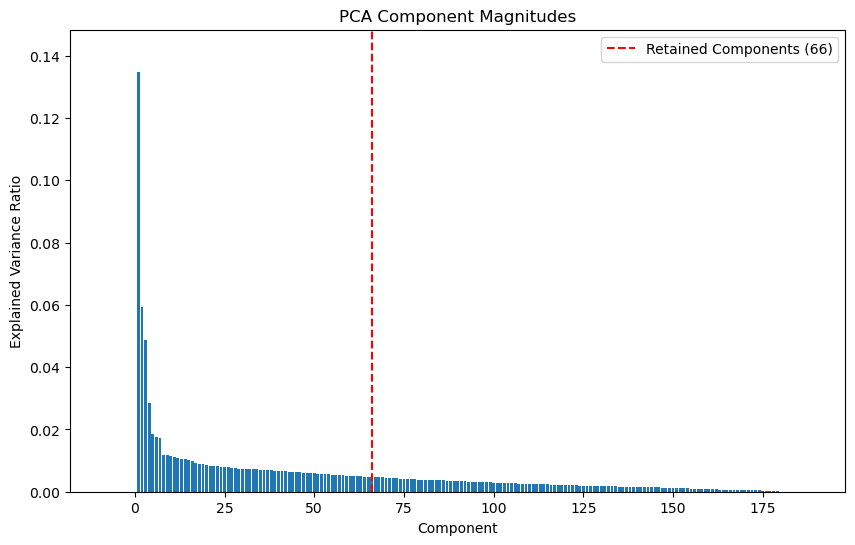

In [123]:
# Plot PCA component for magnitudes
explained_variance_ratio = pca.explained_variance_ratio_
num_components_to_keep = reduced_components.shape[1]
print('components energy length:', explained_variance_ratio.shape)
print('num_components_to_keep:', num_components_to_keep) 
plot_pca_components(explained_variance_ratio, num_components_to_keep)

In [124]:
# Reconstruct the audio from reconstructed components
reconstructed_audio = rebuild_audio_spectrum(components, reduced_components, pca, spectrum_phases, spectrum_shape, segments, n_fft)
print('reconstructed_audio', reconstructed_audio.shape)

# Save the reconstructed audio
print('Writing reconstructed audio to files...')
for i, f in enumerate(files):
    if i % (len(files) // 10) == 0:
        print(f"{int(i/len(files)*100)}/100%")
    # Output file path
    output_file_path = f.replace('.wav', '_pca.wav')
    start = i * len(segments[0]) * segments_by_file[i]
    end = (i + 1) * len(segments[0]) * segments_by_file[i]

    # Save the reconstructed audio
    sf.write(output_file_path, reconstructed_audio[start:end], sr)
    # print(f"Reconstructed audio saved to {output_file_path}")

Rebuilding audio...
reduced_components: (180, 180)
Applying inverse PCA ...
reconstructed_features: (180, 961450)
reconstructed_spectrum: (180, 961450)
Reconstructing audio segments...
0/100%
10/100%
20/100%
30/100%
40/100%
50/100%
60/100%
70/100%
80/100%
90/100%
reconstructed_audio (86400000,)
0/100%
10/100%
20/100%
30/100%
40/100%
50/100%
60/100%
70/100%
80/100%
90/100%


In [125]:
# # Play the original audio
# ipd.Audio(file_path)

In [126]:
# # Play the reconstructed audio
# ipd.Audio(temp_folder_2)

In [127]:
# # Process files using LPC as feature
# # Example usage
# segment_duration = 2
# num_components = 90  # Keep {num_components}% of the variance

# # Load and segment the audio
# segments, sr = load_and_segment(file_path, segment_duration)

# # Apply PCA to LPC features and get PCA object and LPC features
# components, pca, lpc_features, lpc_original = apply_pca_lpc(segments, sr, num_components, order=2 * sr // 1000)

# # Plot PCA component magnitudes
# explained_variance_ratio = pca.explained_variance_ratio_
# num_components_to_keep = len(components[0])
# plot_pca_components(components, explained_variance_ratio, num_components_to_keep)

# # Rebuild the audio from reconstructed LPC features
# reconstructed_audio = rebuild_audio_lpc(components, pca, lpc_features, lpc_original, segments, sr)

# # Save the reconstructed audio
# # Get the path to the Temp folder of the current Windows user
# temp_folder_1 = os.path.join(r'C:\Users\tfmac\Temp', 'reconstructed_audio_lpc.wav')

# # Save the reconstructed audio
# sf.write(temp_folder_1, reconstructed_audio, sr)

# print(f"Reconstructed audio saved to {temp_folder_1}")

In [128]:
# # Play the original audio
# ipd.Audio(file_path)

In [129]:
# # Play the reconstructed audio
# ipd.Audio(temp_folder_1)